## Synthetic Model

Playing with using random sampling to emulate a model with a parameterised performance level.

Approach:

- For each label, choose a target error rate (when the model is given a sample belonging to a class, in what proportion of cases does it fail to predict that class? I.e. 1 - recall for that class)
- Fit a beta distribution so the CDF at 0.5 is the `error_rate` for the positive class (correct prediction has score > 0.5), and `1 - error_rate` for the negative class (correction prediction has score < 0.5)
- Simulate a simple model by sampling from the fitted beta distributions for each label.
- First attempt of considering how imbalance should impact the likely error rates.
  - For example, a classifier that always predicts the majority (negative) class would:
    -  NEVER predict positive when the label should be negative (low error rate for the negative class)
    -  ALWAYS predict negative when the class should be positive (high error rate for the positive class)
  - Currently trying an error rate of `imbalance / model_adv` for the negative class, and `(1 - imbalance) / model_adv` for the positive class.
    - Imbalance is the fraction of positive labels in the dataset
    - `model_adv` is a hyperparameter that attemps to encode how much better than the baseline of only predicting the majority class the simulated model is. `model_adv = 1` should approximate the baseline. `model_adv > 1` should be better than the baseline.
  - This bakes in a lot of assumptions about how difficulty scales with imbalance, and seems to result in precision and recall having very similar values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import beta
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
)

In [12]:
N = 1000
imbalance = 0.1 # fraction of positive labels
model_adv = 10  # hack used to determine error rates

### Positive Class

```
b = 2
a > b
pred > 0.5 for err_rate of samples
```

In [3]:
b_positive = 2
positive_err_rate = (1 - imbalance) / model_adv

def loss_positive(a):
    #if a < b_positive:
    #    return np.inf
    if a <= 0:
        return np.inf
    candidate = beta(a, b_positive)
    return (candidate.cdf(0.5) - positive_err_rate)**2


result = minimize(loss_positive, 2.1, tol=1e-9)
print(result, "\n")
a_positive = float(result.x[0])

beta_positive = beta(a_positive, b_positive)
print(f"{a_positive=:.2f}, {b_positive=:.2f}")
print(
    f"err_rate: got={beta_positive.cdf(0.5)}, "
    f"want={positive_err_rate} (err "
    f"{beta_positive.cdf(0.5) - positive_err_rate:.2e})"
)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.5857564148754712e-19
        x: [ 5.352e+00]
      nit: 12
      jac: [-2.470e-12]
 hess_inv: [[ 1.988e+02]]
     nfev: 26
     njev: 13 

a_positive=5.35, b_positive=2.00
err_rate: got=0.09000000039821557, want=0.09 (err 3.98e-10)


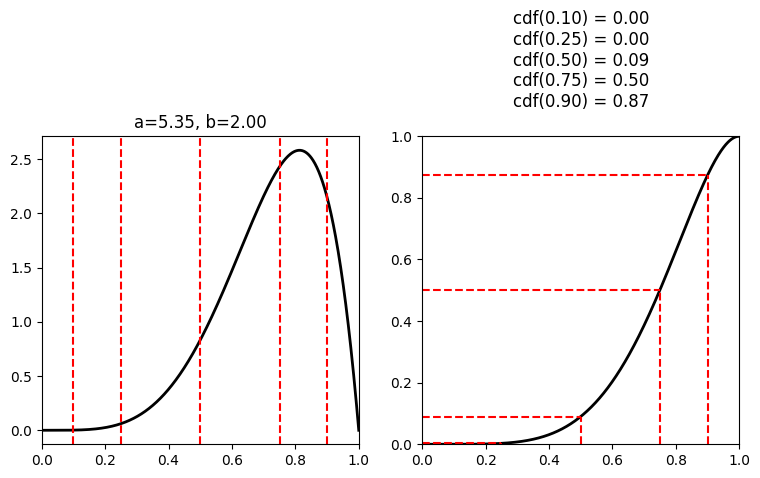

In [4]:
def plot_beta(rv, check_cdfs=(0.1, 0.25, 0.5, 0.75, 0.9)):
    cdf_vals = [rv.cdf(p) for p in check_cdfs]
    cdf_str = ""
    for p, v in zip(check_cdfs, cdf_vals, strict=False):
        cdf_str += f"cdf({p:.2f}) = {v:.2f}\n"

    x = np.linspace(0, 1, N)
    pdf = rv.pdf(x)
    cdf = rv.cdf(x)

    fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
    ax[0].plot(x, pdf, "k-", lw=2)
    for p in check_cdfs:
        ax[0].axvline(p, color="r", linestyle="--")
    a = rv.args[0]
    b = rv.args[1]
    ax[0].set_title(f"{a=:.2f}, {b=:.2f}")
    ax[1].plot(x, cdf, "k-", lw=2)
    for p, v in zip(check_cdfs, cdf_vals, strict=False):
        ax[1].plot([p, p], [0, v], "r--")
        ax[1].plot([0, p], [v, v], "r--")
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_title(cdf_str)


plot_beta(beta_positive)

np.float64(0.101)

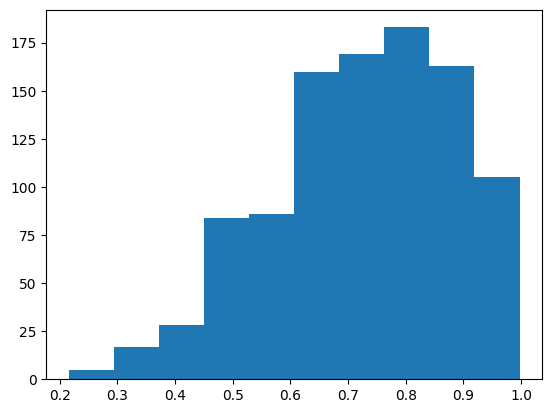

In [5]:
samples = np.random.beta(a_positive, b_positive, N)
(samples > 0.5).mean()
plt.hist(samples)
(samples < 0.5).mean()

### negative class

```
a = 2
b > a
pred < 0.5 for (1 - err_rate) of samples
```

In [6]:
a_negative = 2
negative_err_rate = imbalance / model_adv

def loss_positive(b):
    #if b < a_negative:
    #    return np.inf
    if b <= 0:
        return np.inf
    candidate = beta(a_negative, b)
    return (candidate.cdf(0.5) - (1 - negative_err_rate))**2


result = minimize(loss_positive, 2.1, tol=1e-9)
print(result, "\n")
b_negative = float(result.x[0])

beta_negative = beta(a_negative, b_negative)
print(f"{a_negative=:.2f}, {b_negative=:.2f}")
print(
    f"err_rate: got={1 - beta_negative.cdf(0.5)}, "
    f"want={negative_err_rate} (err "
    f"{beta_negative.cdf(0.5) - (1 - negative_err_rate):.2e})"
)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.5167383069199713e-20
        x: [ 9.119e+00]
      nit: 18
      jac: [-9.436e-13]
 hess_inv: [[ 1.373e+04]]
     nfev: 38
     njev: 19 

a_negative=2.00, b_negative=9.12
err_rate: got=0.010000000123155939, want=0.01 (err -1.23e-10)


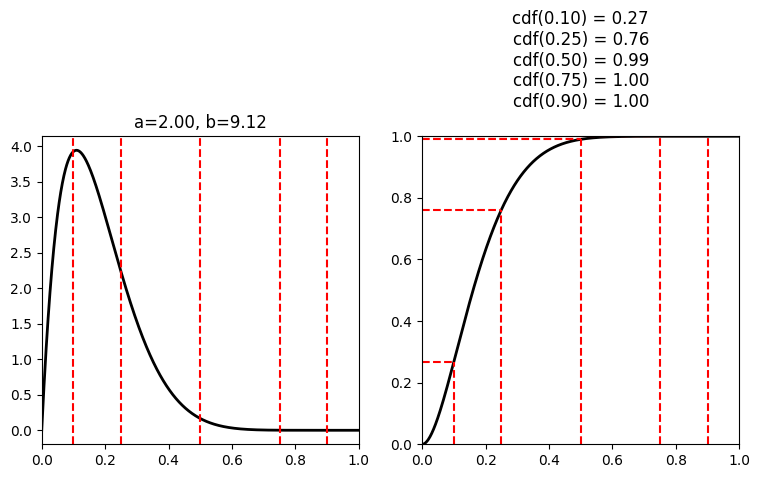

In [7]:
plot_beta(beta_negative)

np.float64(0.994)

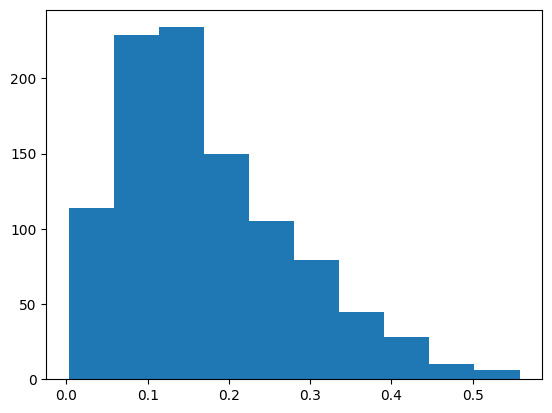

In [8]:
samples = np.random.beta(a_negative, b_negative, N)
(samples > 0.5).mean()
plt.hist(samples)
(samples < 0.5).mean()

### model

In [9]:
def model(label):
    if label == 1:
        return np.random.beta(a_positive, b_positive)
    return np.random.beta(a_negative, b_negative)


pos_preds = [model(1) for _ in range(N)]
neg_preds = [model(0) for _ in range(N)]

print(np.mean([x > 0.5 for x in pos_preds]), f"(expected {1-positive_err_rate:.2f})")
print(np.mean([x < 0.5 for x in neg_preds]), f"(expected {1-negative_err_rate:.2f})")

0.917 (expected 0.91)
0.989 (expected 0.99)


In [10]:
labels = (np.random.random(N) < imbalance).astype(int)
preds = [model(label) for label in labels]
pred_labels = (np.array(preds) > 0.5).astype(int)

In [11]:
precision = precision_score(labels, pred_labels)
recall = recall_score(labels, pred_labels)
f1 = f1_score(labels, pred_labels)

print(f"{precision=:.3f}, {recall=:.3f}, {f1=:.3f}")

precision=0.945, recall=0.887, f1=0.915
